# Load data

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('heart.csv')

# Analysis

In [3]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
dataset.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [5]:
# Need to have all the values in float64
import numpy as np

dataset = dataset.astype(np.float64)

In [63]:
import matplotlib.pyplot as plt

%matplotlib inline

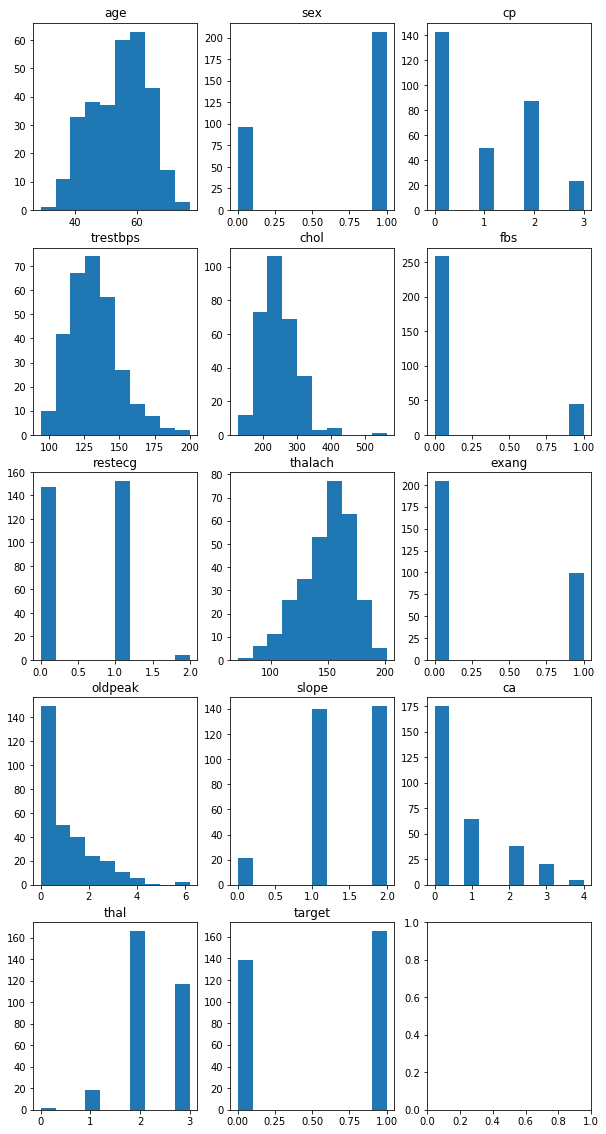

In [7]:
fig, ax = plt.subplots(5, 3)

for i, column_name in enumerate(dataset.columns):
    a, b = i // 3, i % 3
    
    dat = dataset[column_name]
    
    ax[a, b].hist(dat)
    ax[a, b].set_title(column_name)

fig.set_size_inches(10, 20)

plt.show()

# Split into train / test

In [8]:
from sklearn.model_selection import train_test_split

random_state = 12345

x_train, x_test, y_train, y_test = train_test_split(
    dataset.values[:, :-1], dataset.values[:, -1],
    random_state=random_state)

# Create Model Pipeline

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
clf = LogisticRegression(random_state=random_state, solver='liblinear')

model = make_pipeline(scaler, clf)

In [53]:
# Look at the pipeline params just to make sure that I have the right names for things

model.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=12345,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=12345,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': Fa

# Do K-fold CV

In [54]:
hp_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': np.linspace(0.1, 3.0, 100)
}

num_folds = 10

In [55]:
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import log_loss

k_fold = KFold(num_folds)
grid = ParameterGrid(hp_grid)

rows = list()

for params in grid:
    
    model.set_params(**params)
    
    y_hat = np.zeros_like(y_train)

    for train_index, valid_index in k_fold.split(x_train, y_train):
    
        x_train_this_fold = x_train[train_index]
        x_valid = x_train[valid_index]
        y_train_this_fold = y_train[train_index]
        
        model.fit(x_train_this_fold, y_train_this_fold)
        
        y_hat[valid_index] = model.predict(x_valid)
    
    loss = log_loss(y_train, y_hat)
    
    new_row = {'loss': loss, **params}
    rows.append(new_row)

# Select Best HPs

In [56]:
results = pd.DataFrame(rows)

results.sort_values('loss').head()

,logisticregression__C,logisticregression__penalty,loss
14,0.305051,l1,5.325439
16,0.334343,l1,5.477596
6,0.187879,l1,5.477596
8,0.217172,l1,5.477596
10,0.246465,l1,5.477596


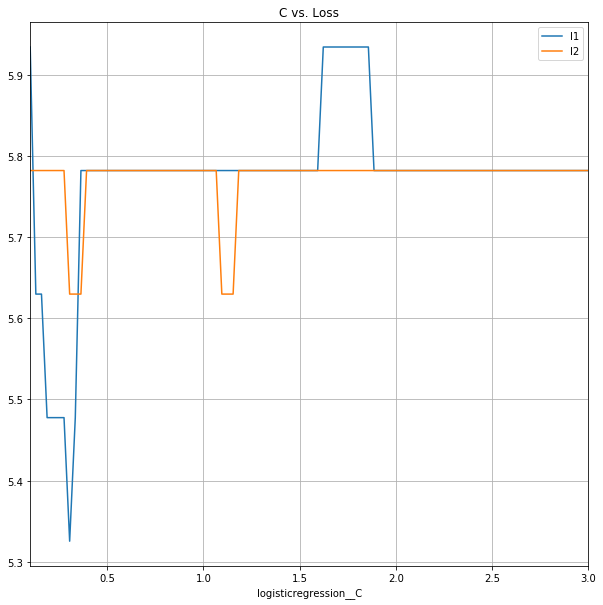

In [61]:
fig, ax = plt.subplots()

for label, d in results.groupby('logisticregression__penalty'):
    d.plot('logisticregression__C', 'loss', label=label, ax=ax)
    
ax.set_title('C vs. Loss')
ax.grid()

fig.set_size_inches(10, 10)

Looks like the winner was L1-norm with `C = 0.305051`.

# Train on full dataset with best params

In [57]:
best_params = {
    'logisticregression__penalty': 'l1',
    'logisticregression__C': 0.305051,
}

model.set_params(**best_params)
model.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.305051, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1',
          random_state=12345, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False))])

# Get the final testing accuracy

In [58]:
from sklearn.metrics import accuracy_score

y_hat = model.predict(x_test)

accuracy = accuracy_score(y_test, np.round(y_hat))

print('Accuracy: {:.3}'.format(accuracy))

Accuracy: 0.789


# Save the model for later use

In [59]:
import pickle

model_file_path = 'final_model.pkl'

with open(model_file_path, 'wb') as f:
    pickle.dump(model, f)